In [6]:
# Reading in neccessary packages
import pandas as pd
import numpy as np
from project_functions.analysis_functions import plot, mse, transform, saveModel, loadModel, modelTraining, createUsableDF, score, boostModel

# This package only neccessary if you would like to re-download the data int the nexyt
# import yahoo_finance as yf

In [7]:
# object = yf.Ticker('PEP')
# data = object.history(start="2000-01-01", end="2020-11-17")
# data.to_csv('Data/Raw Data/pepsi.csv')
data = pd.read_csv('Data/Raw Data/pepsi.csv', index_col='Date')

In [8]:
# This defines the numpy of days in the past we will use to predict the current price
LAG = 40

In [9]:
xTrain, yTrain, xTest, yTest, scaler = transform(data, LAG)

In [10]:
# model = modelTraining(2000, 10,xTrain, yTrain)
# saveModel(model, "pepsiModel", location='Data/Final Models')
model = loadModel(name="pepsiModel", location='Data/Final Models')

MSE Train: 0.3905062042188134
MSE Test: 364.5141882238961


C:\Users\Aidan\Documents\GitRepositories\cmpt-353-stock-market-predictor\project_functions\analysis_functions.py:211: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


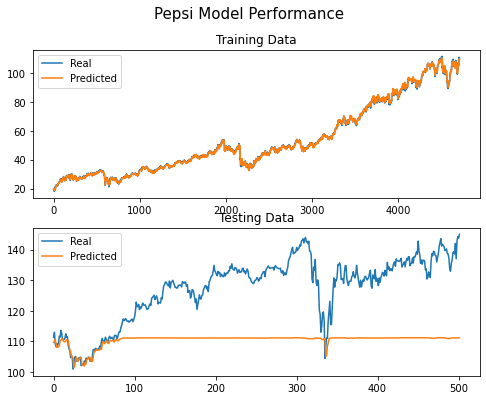

In [12]:
mseTrain, trainPreds, trainTruth = mse(xTrain,yTrain, model, scaler)
print("MSE Train:", mseTrain)

mseTest, testPreds, testTruth = mse(xTest,yTest, model, scaler)

print("MSE Test:", mseTest)

plot(trainTruth, trainPreds, testTruth, testPreds, 'Pepsi Model Performance')